In [8]:
# Import the Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score


Using Dropout https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success Data.

In [9]:
# Load the datasets
df = pd.read_csv("dropoutData.csv")
df.shape


(3630, 35)

In [10]:
train_ratio = 0.7


# split whole into train and test, then split test into val and test
X_train, X_test, y_train, y_test = train_test_split(df.drop('Target', axis=1), df['Target'], train_size=train_ratio, random_state=123)



In [11]:
val_ratio = 0.15
test_ratio = 0.15

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=val_ratio/(val_ratio + test_ratio), random_state=123)
n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]
n = n_train + n_val + n_test
print(f'No. of train samples: {X_train.shape} \n')
print(f'No. of val samples: {X_val.shape} \n')
print(f'No. of test samples: {X_test.shape} \n')
print(f'No. of train samples: {y_train.shape} \n')
print(f'No. of val samples: {y_val.shape} \n')
print(f'No. of test samples: {y_test.shape} \n')
print(f'Train test val ratio: {n_train/n}, {n_test/n}, {n_val/n}')

No. of train samples: (2541, 34) 

No. of val samples: (544, 34) 

No. of test samples: (545, 34) 

No. of train samples: (2541,) 

No. of val samples: (544,) 

No. of test samples: (545,) 

Train test val ratio: 0.7, 0.15013774104683195, 0.14986225895316804


In [12]:
# converting dataframe to numpy array because pytorch takes numpy arrays (or torch.tensor) as input.
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()
X_val=X_val.to_numpy()
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()
y_val=y_val.to_numpy()
type(X_train)
print(f'No. of train samples: {X_train.shape} \n')
print(f'No. of val samples: {X_val.shape} \n')
print(f'No. of test samples: {X_test.shape} \n')
print(f'No. of train samples: {y_train.shape} \n')
print(f'No. of val samples: {y_val.shape} \n')
print(f'No. of test samples: {y_test.shape} \n')

No. of train samples: (2541, 34) 

No. of val samples: (544, 34) 

No. of test samples: (545, 34) 

No. of train samples: (2541,) 

No. of val samples: (544,) 

No. of test samples: (545,) 



In [13]:
from torch.utils.data import DataLoader, TensorDataset
import torch

In [14]:
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
val_dataset= TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())
test_dataset=TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long())


In [15]:
## Dataloader

train_bs = 32
val_bs = 32
test_bs = 32
#Batchsize is a Hyperparameter, it is a tradeoff between speed and accuracy.

train_dataloader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True, drop_last=True) #dataset
val_dataloader = DataLoader(val_dataset, batch_size=val_bs, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_bs, shuffle=False, drop_last=True)

# train_dataloader

print(f'No. of batches train dataloader: {len(train_dataloader)} and total train samples: {len(train_dataloader)*train_bs}, {train_dataloader.batch_size}')
print(f'No. of batches val dataloader: {len(val_dataloader)} and total val samples: {len(val_dataloader)*val_bs}')
print(f'No. of batches test dataloader: {len(test_dataloader)} and test train samples: {len(test_dataloader)*test_bs}')
# X = next(iter(train_dataloader))

# (X,y) = next(iter(train_dataloader))

No. of batches train dataloader: 79 and total train samples: 2528, 32
No. of batches val dataloader: 17 and total val samples: 544
No. of batches test dataloader: 17 and test train samples: 544


In [16]:
# print(X[1])

In [17]:
# Train and evaluate functions for training and validating the model

def train_loop(model, tr_dataloader, loss_fn, opt):
    avg_loss = 0 # to store running loss
    model.train() # Set model in training mode
    for batch_idx, (X, y) in enumerate(tr_dataloader):
        pred = model(X) # make prediction on current batch
        loss = loss_fn(pred,y) # calculate loss
        loss.backward() # calculates gradients
        opt.step() # update weights
        opt.zero_grad() # set gradients to zero for next batch
        avg_loss += loss.item()
        #print(f'Batch no. {batch_idx}, Batch loss: {loss.item():.5f}')
    print(f'Average training Loss: {avg_loss/len(tr_dataloader):.5f}')
    train_loss = avg_loss/len(tr_dataloader)
    return train_loss

def test_loop(model, dataloader, loss_fn ):
    test_loss = 0.
    correct = 0
    model.eval()
    bs = dataloader.batch_size
    for batch_idx, (X, y) in enumerate(dataloader):
        pred = model(X) # make prediction on current batch
        test_loss += loss_fn(pred,y).item() # calculate loss
        correct += (pred.argmax(1) == y).type(torch.float).sum().item() # not required for regression

    test_loss /= len(dataloader)
    correct /= (len(dataloader)*dataloader.batch_size)
    print(f'Error: \n Accuracy: {(100*correct):0.1f}%, Avg test loss: {test_loss:.5f} \n')


    return test_loss


In [18]:
# define a model class # Model 1
from torch import nn, optim

class Network(nn.Module):
    def __init__(self,hid_layer=[100,100]):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(34, hid_layer[0]),
            nn.ReLU(),
            nn.Linear(hid_layer[0],hid_layer[1]),
            nn.ReLU(),
            nn.Linear(hid_layer[1], 2),
        )
    def forward(self,x):
        logits = self.net(x)
        return logits



In [19]:
## Calling model 1
hid_layer = [80,45] # number of nodes
model = Network(hid_layer) #instantiate

epochs = 20 #Hyperparameter
learning_rate = 1e-2 
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)
train_loss = [] # list to store train loss
val_loss = [] # list to store val loss

for t in range(epochs):
    print(f'Epoch {t}')
    train_loss.append(train_loop(model, train_dataloader,  loss_fn, opt)) # to plot the graph
    val_loss.append(test_loop(model, val_dataloader, loss_fn))



Epoch 0
Average training Loss: 0.46858
Error: 
 Accuracy: 91.2%, Avg test loss: 0.26643 

Epoch 1
Average training Loss: 0.30493
Error: 
 Accuracy: 89.3%, Avg test loss: 0.28162 

Epoch 2
Average training Loss: 0.27269
Error: 
 Accuracy: 91.5%, Avg test loss: 0.21538 

Epoch 3
Average training Loss: 0.28239
Error: 
 Accuracy: 91.5%, Avg test loss: 0.24279 

Epoch 4
Average training Loss: 0.25450
Error: 
 Accuracy: 92.1%, Avg test loss: 0.20797 

Epoch 5
Average training Loss: 0.25574
Error: 
 Accuracy: 88.8%, Avg test loss: 0.31898 

Epoch 6
Average training Loss: 0.25852
Error: 
 Accuracy: 91.9%, Avg test loss: 0.20949 

Epoch 7
Average training Loss: 0.24917
Error: 
 Accuracy: 91.0%, Avg test loss: 0.23390 

Epoch 8
Average training Loss: 0.23037
Error: 
 Accuracy: 92.5%, Avg test loss: 0.20871 

Epoch 9
Average training Loss: 0.24839
Error: 
 Accuracy: 92.1%, Avg test loss: 0.21681 

Epoch 10
Average training Loss: 0.24260
Error: 
 Accuracy: 93.0%, Avg test loss: 0.20841 

Epoch 11


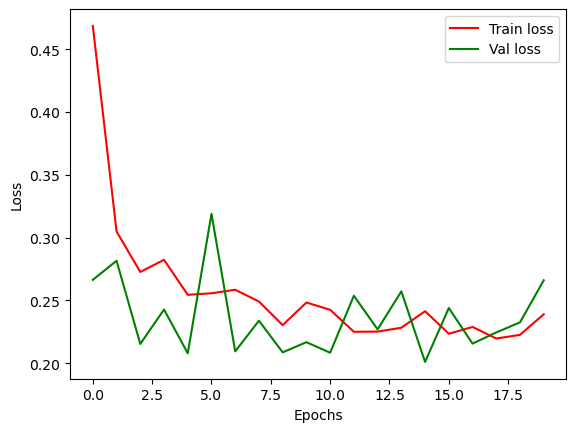

In [20]:

from matplotlib import pyplot as plt
xax = range(epochs)
plt.plot(xax, np.array(train_loss),'r-', xax, np.array(val_loss),'g-'  )
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train loss','Val loss' ])
plt.show()

In [21]:
print('Performing test...\n')
test_loop(model,test_dataloader,loss_fn)

Performing test...

Error: 
 Accuracy: 87.3%, Avg test loss: 0.39276 



0.3927621525876662

In [25]:
# define a model class # Model 2

class Network2(nn.Module):
    def __init__(self,hid_layer=[100]):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(34, hid_layer[0]),
            nn.ReLU(),
            nn.Linear(hid_layer[0], 2)
        )
    def forward(self,x):
        logits = self.net(x)
        return logits

In [26]:
## Calling model 2
hid_layer2 = [80] # number of nodes
model2 = Network2(hid_layer2) #instantiate

epochs = 20 #Hyperparameter
learning_rate = 1e-2 
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model2.parameters(), lr=learning_rate)
train_loss = [] # list to store train loss
val_loss = [] # list to store val loss

for t in range(epochs):
    print(f'Epoch {t}')
    train_loss.append(train_loop(model2, train_dataloader,  loss_fn, opt)) # to plot the graph
    val_loss.append(test_loop(model2, val_dataloader, loss_fn))

Epoch 0
Average training Loss: 0.40071
Error: 
 Accuracy: 91.4%, Avg test loss: 0.23076 

Epoch 1
Average training Loss: 0.28044
Error: 
 Accuracy: 91.2%, Avg test loss: 0.22686 

Epoch 2
Average training Loss: 0.25850
Error: 
 Accuracy: 92.6%, Avg test loss: 0.20806 

Epoch 3
Average training Loss: 0.26971
Error: 
 Accuracy: 91.5%, Avg test loss: 0.23947 

Epoch 4
Average training Loss: 0.24613
Error: 
 Accuracy: 93.0%, Avg test loss: 0.21098 

Epoch 5
Average training Loss: 0.23687
Error: 
 Accuracy: 91.2%, Avg test loss: 0.25076 

Epoch 6
Average training Loss: 0.23626
Error: 
 Accuracy: 91.4%, Avg test loss: 0.22888 

Epoch 7
Average training Loss: 0.23765
Error: 
 Accuracy: 93.6%, Avg test loss: 0.20783 

Epoch 8
Average training Loss: 0.25551
Error: 
 Accuracy: 93.4%, Avg test loss: 0.23433 

Epoch 9
Average training Loss: 0.25091
Error: 
 Accuracy: 93.0%, Avg test loss: 0.20658 

Epoch 10
Average training Loss: 0.22666
Error: 
 Accuracy: 92.8%, Avg test loss: 0.21558 

Epoch 11


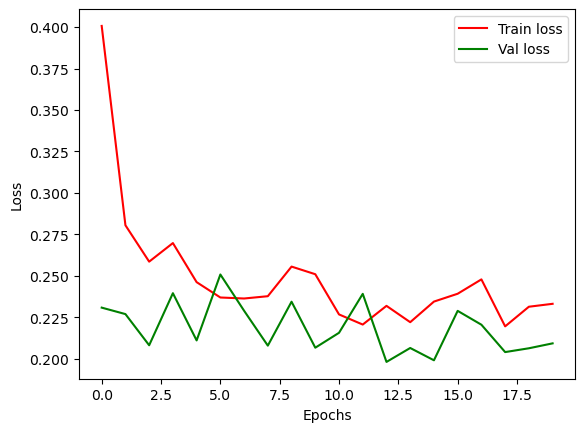

In [27]:
xax = range(epochs)
plt.plot(xax, np.array(train_loss),'r-', xax, np.array(val_loss),'g-'  )
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train loss','Val loss' ])
plt.show()

In [29]:
print('Performing test...\n')
test_loop(model2,test_dataloader,loss_fn)

Performing test...

Error: 
 Accuracy: 87.7%, Avg test loss: 0.33668 



0.33668413495316224